<a href="https://colab.research.google.com/github/bdgToji/VNP/blob/main/KOL2_TSF_XGBR_2024.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Time-series Forecasting

## Description
The data consists of 52,416 observations of energy consumption on a 10-minute window. Every observation is described by the following feature columns.

Your task is to **aggregate the observations on an interval of 38 minutes**. For this time interval, using the values of the **9 previous time intervals**, forecast the target value one step in the future. Choose which features you are going to use.

**You must train an LSTM network.**



Features:

* TimePeriod: Time window of ten minutes.
* WT: Weather Temperature.
* WH: Weather Humidity.
* WS: Wind Speed.
* GDF: General Diffuse Flow. “Diffuse flow” is a catchall term to describe low-temperature (< 0.2° to ~ 100°C) fluids that slowly discharge through sulfide mounds, fractured lava flows, and assemblages of bacterial mats and macrofauna.
* DF: DiffuseFlows

Target:

Consumption

## Dateset links:
 * [DS1](https://drive.google.com/file/d/1-8neeIpiq6yzWVw4EG_WgzHX4kPH1n1j/view?usp=sharing)
 * [DS2](https://drive.google.com/file/d/1-LhrUaH59q8O0SYB8WE-Eov2gaTMQYVx/view?usp=sharing)

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import pandas as pd
import numpy as np
import keras
from keras.layers import Input, Dense, LSTM, Embedding, concatenate
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential, Model
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import SimpleImputer, IterativeImputer

## Merge the datasets (and pre-process if needed)

In [3]:
df1 = pd.read_csv('/content/drive/MyDrive/VNP/power_consumption_g4.csv')
df2 = pd.read_csv('/content/drive/MyDrive/VNP/power_consumption_g4_feat.csv')

## Group the datasets into time intervals of 1 hour

In [4]:
df1

,TimePeriod,Consumption
0,2017-12-02 20:10:00,36824.33460
1,2017-12-25 15:30:00,31841.82510
2,2017-05-19 21:10:00,44909.11475
3,2017-05-28 04:50:00,22964.45902
4,2017-05-08 16:10:00,33829.77049
...,...,...
52411,2017-10-01 23:50:00,31138.03063
52412,2017-12-07 17:40:00,40091.25475
52413,2017-09-11 18:30:00,38930.97345
52414,2017-04-16 04:50:00,23734.42411


In [5]:
df1.isna().sum()

TimePeriod     0
Consumption    0
dtype: int64

In [6]:
df2

,TimePeriod,WT,WH,WS,GDF,DF
0,2017-03-01 16:40:00,21.33,55.91,0.080,387.400,427.300
1,2017-07-27 06:30:00,23.10,48.58,4.908,10.450,8.630
2,2017-10-11 19:00:00,23.10,59.82,0.084,0.446,0.322
3,2017-02-10 06:50:00,12.25,80.80,4.916,0.051,0.111
4,2017-03-06 16:00:00,15.62,59.38,0.075,533.400,579.900
...,...,...,...,...,...,...
52411,2017-05-14 02:20:00,23.58,43.10,0.075,0.110,0.122
52412,2017-11-17 19:20:00,17.30,76.50,0.075,0.040,0.148
52413,2017-03-21 12:10:00,17.90,50.28,0.081,837.000,296.700
52414,2017-07-28 05:10:00,25.23,61.32,4.907,0.091,0.119


In [7]:
df2.isna().sum()

TimePeriod      0
WT            559
WH            499
WS            529
GDF           524
DF            505
dtype: int64

In [8]:
columns = df2.columns[1:]

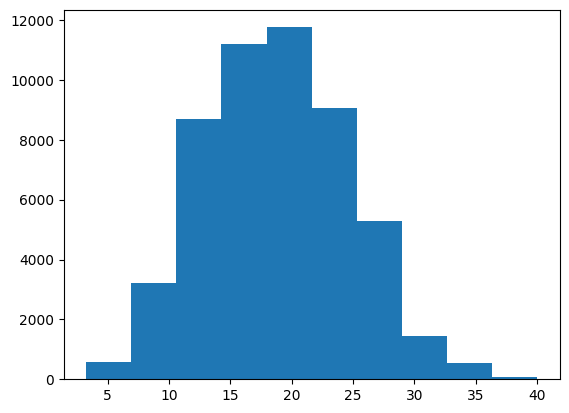

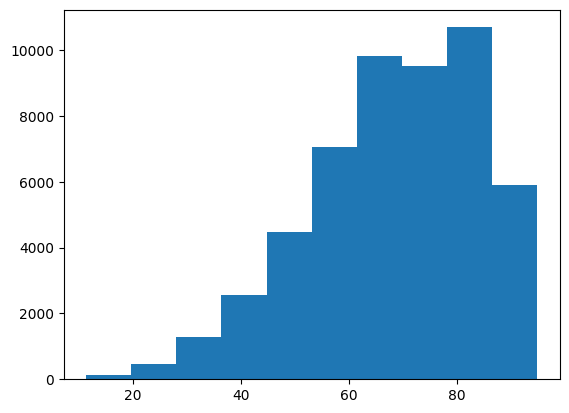

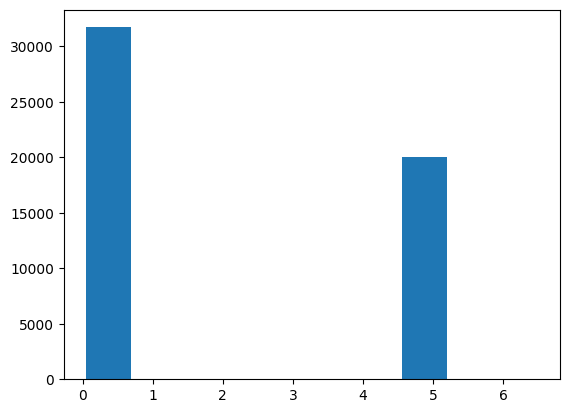

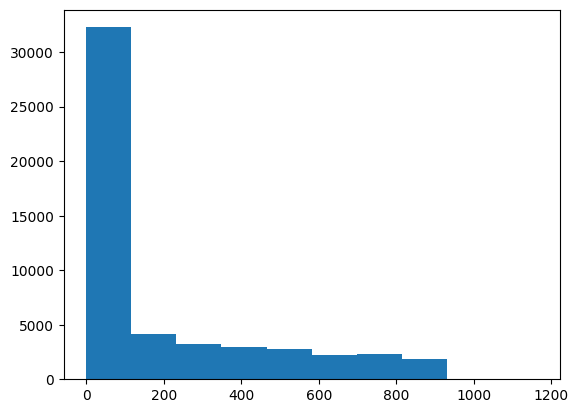

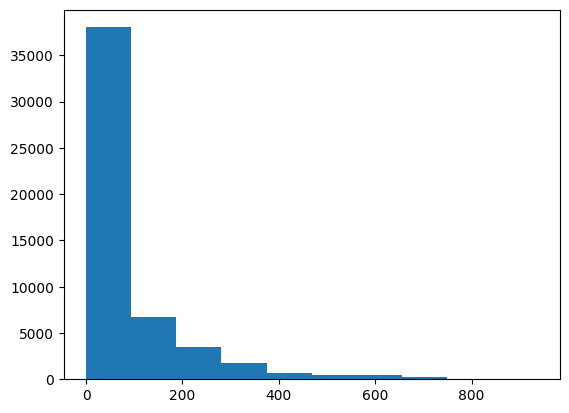

In [9]:
for col in columns:
  plt.figure()
  plt.hist(df2[col])

In [10]:
imputer = SimpleImputer(strategy='mean', fill_value=df2['WT'].mean())
df2['WT'] = imputer.fit_transform(df2['WT'].to_numpy().reshape(-1,1)).flatten()

In [11]:
iterative_imputer = IterativeImputer(random_state=0)
df2['WH'] = iterative_imputer.fit_transform(df2['WH'].to_numpy().reshape(-1,1))

iterative_imputer = IterativeImputer(random_state=0)
df2['WS'] = iterative_imputer.fit_transform(df2['WS'].to_numpy().reshape(-1,1))

iterative_imputer = IterativeImputer(random_state=0)
df2['GDF'] = iterative_imputer.fit_transform(df2['GDF'].to_numpy().reshape(-1,1))

iterative_imputer = IterativeImputer(random_state=0)
df2['DF'] = iterative_imputer.fit_transform(df2['DF'].to_numpy().reshape(-1,1))

In [12]:
df2.isna().sum()

TimePeriod    0
WT            0
WH            0
WS            0
GDF           0
DF            0
dtype: int64

In [13]:
df1 = df1.sort_values('TimePeriod')
df2 = df2.sort_values('TimePeriod')

In [14]:
df1['TimePeriod'] = pd.to_datetime(df1['TimePeriod'])
df1 = df1.groupby(pd.Grouper(key='TimePeriod', freq='1h')).mean()

df2['TimePeriod'] = pd.to_datetime(df2['TimePeriod'])
df2 = df2.groupby(pd.Grouper(key='TimePeriod', freq='1h')).mean()

In [18]:
df = df2.merge(df1, left_on='TimePeriod', right_on='TimePeriod')

In [19]:
df

,WT,WH,WS,GDF,DF,Consumption
TimePeriod,,,,,,
2017-01-01 00:00:00,8.356946,75.066667,0.081833,0.063500,0.098833,29197.974683
2017-01-01 01:00:00,5.548833,75.927520,0.082000,0.056833,0.112500,24657.215190
2017-01-01 02:00:00,5.054333,78.933333,0.082333,0.063000,0.129167,22083.037973
2017-01-01 03:00:00,5.004333,77.083333,0.082833,0.059833,0.141000,20811.139240
2017-01-01 04:00:00,5.097667,74.050000,0.082333,0.058000,0.122833,20475.949367
...,...,...,...,...,...,...
2017-12-30 19:00:00,9.453333,63.492520,0.074667,0.052000,0.102000,37513.814957
2017-12-30 20:00:00,9.041667,63.990000,0.080333,0.052667,0.105000,37008.871988
2017-12-30 21:00:00,8.011667,69.675000,0.081500,0.073167,0.098333,35358.174905


## Create lags

In [21]:
lags = 9

In [20]:
columns = df.columns

In [23]:
for i in range(1, lags+1):
  for col in columns:
    df[f'{col}_prev_{i}'] = df[col].shift(i)

In [24]:
df

,WT,WH,WS,GDF,DF,Consumption,WT_prev_1,WH_prev_1,WS_prev_1,GDF_prev_1,...,WS_prev_8,GDF_prev_8,DF_prev_8,Consumption_prev_8,WT_prev_9,WH_prev_9,WS_prev_9,GDF_prev_9,DF_prev_9,Consumption_prev_9
TimePeriod,,,,,,,,,,,,,,,,,,,,,
2017-01-01 00:00:00,8.356946,75.066667,0.081833,0.063500,0.098833,29197.974683,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-01-01 01:00:00,5.548833,75.927520,0.082000,0.056833,0.112500,24657.215190,8.356946,75.066667,0.081833,0.063500,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-01-01 02:00:00,5.054333,78.933333,0.082333,0.063000,0.129167,22083.037973,5.548833,75.927520,0.082000,0.056833,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-01-01 03:00:00,5.004333,77.083333,0.082833,0.059833,0.141000,20811.139240,5.054333,78.933333,0.082333,0.063000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-01-01 04:00:00,5.097667,74.050000,0.082333,0.058000,0.122833,20475.949367,5.004333,77.083333,0.082833,0.059833,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-12-30 19:00:00,9.453333,63.492520,0.074667,0.052000,0.102000,37513.814957,10.771667,58.323333,0.076500,3.185833,...,0.077667,413.550000,37.781667,30450.697085,12.958333,44.521667,0.076333,293.333333,34.770000,28848.669200
2017-12-30 20:00:00,9.041667,63.990000,0.080333,0.052667,0.105000,37008.871988,9.453333,63.492520,0.074667,0.052000,...,0.078000,482.016667,38.356667,30621.039290,13.806667,42.128333,0.077667,413.550000,37.781667,30450.697085
2017-12-30 21:00:00,8.011667,69.675000,0.081500,0.073167,0.098333,35358.174905,9.041667,63.990000,0.080333,0.052667,...,0.077333,497.666667,38.553333,30359.442335,14.300000,39.181667,0.078000,482.016667,38.356667,30621.039290


In [25]:
df = df.dropna(axis=0)

In [26]:
df

,WT,WH,WS,GDF,DF,Consumption,WT_prev_1,WH_prev_1,WS_prev_1,GDF_prev_1,...,WS_prev_8,GDF_prev_8,DF_prev_8,Consumption_prev_8,WT_prev_9,WH_prev_9,WS_prev_9,GDF_prev_9,DF_prev_9,Consumption_prev_9
TimePeriod,,,,,,,,,,,,,,,,,,,,,
2017-01-01 09:00:00,4.609167,73.983333,0.082167,144.800000,25.215000,22905.316455,4.655167,73.600000,0.082667,13.763833,...,0.082000,0.056833,0.112500,24657.215190,8.356946,75.066667,0.081833,0.063500,0.098833,29197.974683
2017-01-01 10:00:00,6.145333,69.635000,3.738500,293.266667,31.875000,26685.569620,4.609167,73.983333,0.082167,144.800000,...,0.082333,0.063000,0.129167,22083.037973,5.548833,75.927520,0.082000,0.056833,0.112500,24657.215190
2017-01-01 11:00:00,9.893333,58.036667,2.088167,371.661139,36.341667,29288.101265,6.145333,69.635000,3.738500,293.266667,...,0.082833,0.059833,0.141000,20811.139240,5.054333,78.933333,0.082333,0.063000,0.129167,22083.037973
2017-01-01 12:00:00,14.846667,57.078333,0.075667,478.850000,40.201667,29889.620255,9.893333,58.036667,2.088167,371.661139,...,0.082333,0.058000,0.122833,20475.949367,5.004333,77.083333,0.082833,0.059833,0.141000,20811.139240
2017-01-01 13:00:00,15.680000,57.071667,0.076667,493.933333,41.761667,30231.898735,14.846667,57.078333,0.075667,478.850000,...,0.081000,0.065833,0.118833,20807.088607,5.097667,74.050000,0.082333,0.058000,0.122833,20475.949367
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-12-30 19:00:00,9.453333,63.492520,0.074667,0.052000,0.102000,37513.814957,10.771667,58.323333,0.076500,3.185833,...,0.077667,413.550000,37.781667,30450.697085,12.958333,44.521667,0.076333,293.333333,34.770000,28848.669200
2017-12-30 20:00:00,9.041667,63.990000,0.080333,0.052667,0.105000,37008.871988,9.453333,63.492520,0.074667,0.052000,...,0.078000,482.016667,38.356667,30621.039290,13.806667,42.128333,0.077667,413.550000,37.781667,30450.697085
2017-12-30 21:00:00,8.011667,69.675000,0.081500,0.073167,0.098333,35358.174905,9.041667,63.990000,0.080333,0.052667,...,0.077333,497.666667,38.553333,30359.442335,14.300000,39.181667,0.078000,482.016667,38.356667,30621.039290


## Split the dataset into 80% training and 20% testing datasets

In [34]:
X, Y = df.drop(columns=['WT','WH','WS','GDF','DF','Consumption']), df['Consumption']

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, shuffle=False)

In [39]:
scaler = MinMaxScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)
Y_train = scaler.fit_transform(Y_train.values.reshape(-1, 1))

## Create the model, pre-process the data and make it suitable for training

In [40]:
from xgboost import cv, DMatrix, plot_importance, XGBRegressor

data_dmatrix = DMatrix(data=X, label=Y)



params = {"objective":"reg:squarederror",'colsample_bytree': 0.7,'learning_rate': 0.01,
                'max_depth': 3}

cv_results = cv(dtrain=data_dmatrix, params=params, nfold=5,
                    num_boost_round=50,early_stopping_rounds=10, metrics="rmse", as_pandas=True, seed=123)

In [41]:
cv_results

,train-rmse-mean,train-rmse-std,test-rmse-mean,test-rmse-std
0,7003.198553,15.450392,7003.742095,62.649449
1,6943.470946,15.323518,6944.310308,62.931606
2,6884.387543,15.254139,6885.575408,63.097865
3,6826.219378,15.157706,6827.835387,63.288683
4,6768.406925,15.072232,6770.160719,63.392086
5,6716.330570,14.428529,6718.358044,63.600491
6,6665.655250,14.651234,6668.086378,62.952923
7,6609.485606,14.416663,6612.091826,63.020691
8,6553.954819,14.231725,6556.742275,62.973458
9,6499.040275,14.096311,6502.086105,63.068832


In [42]:
xgb_reg = XGBRegressor(**params)

In [43]:
xgb_reg.fit(X_train, Y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.7, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

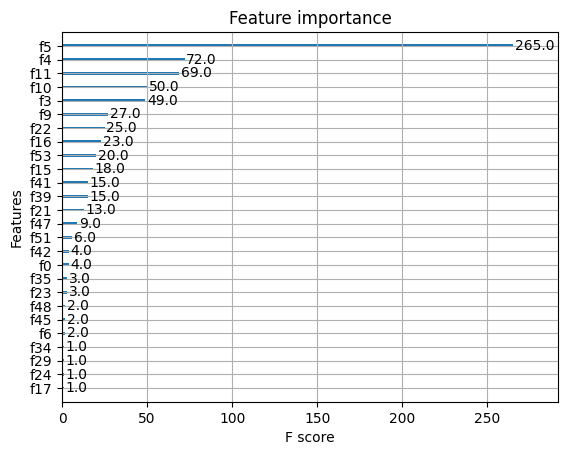

In [44]:
plot_importance(xgb_reg)